In [2]:
include("radial_basis_surrogates.jl")
using Plots

In [61]:
function eval_DKXX(rbf :: RBFfun, X; D)
    M, N = size(X)
    nd1 = N*(D+1)
    K = zeros(nd1, nd1)
    r0 = zeros(M)
    ψ0 = eval_Dk(rbf, r0, D=D)
    s(i) = (i-1)*(D+1)+1
    e(i) = s(i)+D

    for i = 1:N
        # Starting indices
        si, ei = s(i), e(i)
        K[si:ei, si:ei] = ψ0
        # Reduce computations by leveraging symmetric structure of
        # covariance matrix
        for j = i+1:N
            # Row remains stationary as columns (j=i+1) vary as a function
            # of the row index (i)
            sj, ej = s(j), e(j)
            Kij = eval_Dk(rbf, X[:,i]-X[:,j], D=D)
            K[si:ei, sj:ej] = Kij
            K[sj:ej, si:ei] = Kij'
        end
    end

    return K
end

function eval_DKxX(rbf :: RBFfun, x, X; D)
    M, N = size(X)
    KxX = eval_Dk(rbf, x-X[:,1], D=D)
    for j = 2:N
        KxX = hcat(
            KxX,
            eval_Dk(rbf, x-X[:,j], D=D)
        )
    end
    return KxX
end

eval_DKxX (generic function with 2 methods)

In [81]:
ψ = kernel_matern52()
# X = collect(-3:.75:3.)
X = [-2., 2.]
X = reshape(X, 1, length(X))
f(x; noise=0.) = x^3 + noise
∇f(x; noise=0.) = 3x^2 + noise
y = []
for j in 1:length(X)
    push!(y, f(first(X[:,j])))
    push!(y, ∇f(first(X[:,j])))
end
y = Vector{Float64}(y);

In [82]:
DKXX = eval_DKXX(ψ, X; D=1)

4×4 Matrix{Float64}:
  1.0         -0.0         0.00477708  -0.00865035
  0.0          1.66667     0.00865035  -0.0152351
  0.00477708   0.00865035  1.0         -0.0
 -0.00865035  -0.0152351   0.0          1.66667

In [83]:
DKXX = eval_DKXX(ψ, X; D=1)
c = DKXX\y;
eval_DKxX(ψ, [0.], X; D=1)

2×4 Matrix{Float64}:
  0.13866    0.208359  0.13866   -0.208359
 -0.208359  -0.276584  0.208359  -0.276584

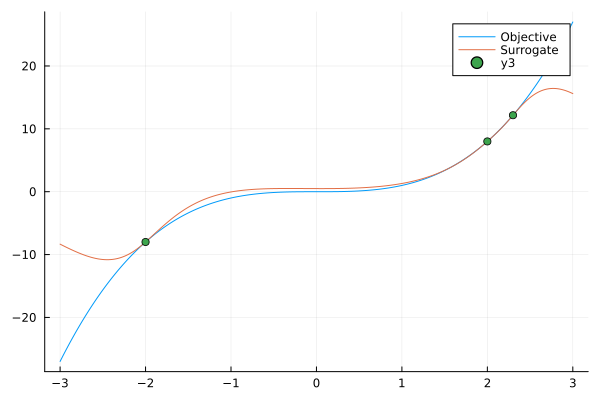

In [77]:
domain = filter(x -> !(x in X), -3:.01:3)
# plot(domain, [x for x in domain])
plot(domain, [f(x) for x in domain], label="Objective")
plot!(
    domain,
    [first(eval_DKxX(ψ, [x], X; D=1)*c) for x in domain],
    label="Surrogate"
)
scatter!(X', y[1:2:end])